# Concept Drift Simulation
## Objective

This notebook demonstrates how concept drift:

- Degrades model performance over time

- Invalidates static validation assumptions

- Requires time-aware evaluation and monitoring

We simulate feature drift, prior drift, and concept drift, and show how models fail when drift is ignored.

## Why Concept Drift Matters

In production:

- Customer behavior changes

- Markets evolve

- Policies and pricing shift

- External shocks occur

Models trained on historical data will decay unless actively monitored.

## Imports and Configuration

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

RANDOM_STATE = 2010
np.random.seed(RANDOM_STATE)


# Step 1 – Generate Time-Indexed Classification Data

We simulate a binary outcome over time.

In [5]:
N_PERIODS = 36        # months
SAMPLES_PER_PERIOD = 300

records = []

for t in range(N_PERIODS):
    marketing_spend = np.random.normal(
        loc=50000 + t * 800,
        scale=8000,
        size=SAMPLES_PER_PERIOD
    )

    price = np.random.normal(
        loc=100 - t * 0.5,
        scale=10,
        size=SAMPLES_PER_PERIOD
    )

    score = (
        -3.0
        + 0.00004 * marketing_spend
        - 0.03 * price
        + np.random.normal(0, 0.6, size=SAMPLES_PER_PERIOD)
    )

    probability = 1 / (1 + np.exp(-score))
    target = np.random.binomial(1, probability)

    records.append(pd.DataFrame({
        "time": t,
        "marketing_spend": marketing_spend,
        "price": price,
        "target": target
    }))

df = pd.concat(records, ignore_index=True)
df.head()


,time,marketing_spend,price,target
0,0,49154.370542,86.259662,0
1,0,45925.627099,102.288018,0
2,0,55875.868551,88.465347,0
3,0,49833.609048,109.377744,0
4,0,30670.742890,106.447043,0


# Step 2 – Visualize Feature Drift

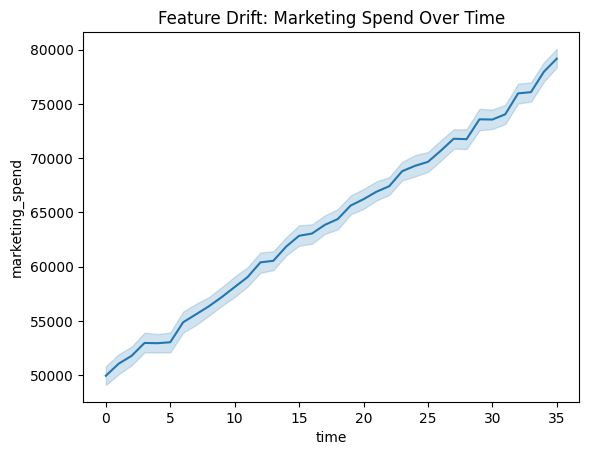

In [3]:
plt.figure()
sns.lineplot(
    data=df,
    x="time",
    y="marketing_spend",
    estimator="mean"
)
plt.title("Feature Drift: Marketing Spend Over Time")
plt.show()


# Step 3 – Train on Early Periods, Test on Later Periods
## Temporal Split

In [6]:
train_cutoff = 18

train_df = df[df["time"] < train_cutoff]
test_df = df[df["time"] >= train_cutoff]

X_train = train_df[["marketing_spend", "price"]]
y_train = train_df["target"]

X_test = test_df[["marketing_spend", "price"]]
y_test = test_df["target"]


## Model Training

In [7]:
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ]
)

pipeline.fit(X_train, y_train)

y_proba = pipeline.predict_proba(X_test)[:, 1]

print("ROC-AUC after Drift:",
      roc_auc_score(y_test, y_proba))


ROC-AUC after Drift: 0.6413698380467941


#  Step 4 – Rolling Performance Degradation

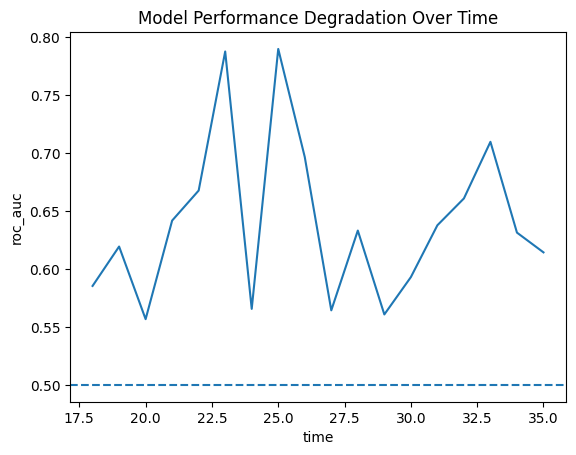

In [8]:
auc_over_time = []

for t in range(train_cutoff, N_PERIODS):
    period_df = df[df["time"] == t]
    X_period = period_df[["marketing_spend", "price"]]
    y_period = period_df["target"]

    y_proba = pipeline.predict_proba(X_period)[:, 1]
    auc = roc_auc_score(y_period, y_proba)
    auc_over_time.append((t, auc))

auc_df = pd.DataFrame(auc_over_time, columns=["time", "roc_auc"])

plt.figure()
sns.lineplot(data=auc_df, x="time", y="roc_auc")
plt.axhline(0.5, linestyle="--")
plt.title("Model Performance Degradation Over Time")
plt.show()


# Step 5 – Prior Probability Drift (Label Shift)
## Simulation

In [9]:
df_prior_drift = df.copy()

mask = df_prior_drift["time"] >= 24
df_prior_drift.loc[mask, "target"] = np.random.binomial(
    1,
    0.7,
    size=mask.sum()
)


## Impact Evaluation

In [10]:
test_df = df_prior_drift[df_prior_drift["time"] >= train_cutoff]

X_test = test_df[["marketing_spend", "price"]]
y_test = test_df["target"]

y_proba = pipeline.predict_proba(X_test)[:, 1]

print("ROC-AUC under Prior Drift:",
      roc_auc_score(y_test, y_proba))


ROC-AUC under Prior Drift: 0.6503213387979979


# Step 6 – True Concept Drift (Changing Relationships)
## Simulation

In [11]:
df_concept_drift = df.copy()

mask = df_concept_drift["time"] >= 20

df_concept_drift.loc[mask, "target"] = np.random.binomial(
    1,
    1 / (
        1 + np.exp(
            -(
                -2.5
                - 0.00003 * df_concept_drift.loc[mask, "marketing_spend"]
                + 0.06 * df_concept_drift.loc[mask, "price"]
            )
        )
    )
)


## Evaluation

In [12]:
test_df = df_concept_drift[df_concept_drift["time"] >= train_cutoff]

X_test = test_df[["marketing_spend", "price"]]
y_test = test_df["target"]

y_proba = pipeline.predict_proba(X_test)[:, 1]

print("ROC-AUC under Concept Drift:",
      roc_auc_score(y_test, y_proba))


ROC-AUC under Concept Drift: 0.41797629272274306


# Step 7 – Retraining Strategy
## Retrain with Recent Data

In [13]:
recent_train = df_concept_drift[
    (df_concept_drift["time"] >= 12) &
    (df_concept_drift["time"] < 24)
]

X_recent = recent_train[["marketing_spend", "price"]]
y_recent = recent_train["target"]

pipeline.fit(X_recent, y_recent)

test_df = df_concept_drift[df_concept_drift["time"] >= 24]
X_test = test_df[["marketing_spend", "price"]]
y_test = test_df["target"]

y_proba = pipeline.predict_proba(X_test)[:, 1]

print("ROC-AUC after Retraining:",
      roc_auc_score(y_test, y_proba))


ROC-AUC after Retraining: 0.3995760659529038


# Step 8 – Business Risks of Ignoring Drift



| Drift Type         | Consequence                 |
| ------------------ | --------------------------- |
| Feature drift      | Input distribution mismatch |
| Prior drift        | Calibration failure         |
| Concept drift      | Strategy inversion          |
| No monitoring      | Silent failure              |
| Delayed retraining | Revenue loss                |




# Step 9 – Monitoring Signals (Conceptual)

Key indicators to track:

- Population Stability Index (PSI)

- Feature distribution shift

- Prediction confidence decay

- Performance on delayed labels

## Summary

This notebook demonstrated:

- Feature drift

- Label (prior) drift

- True concept drift

- Temporal validation necessity

- Retraining impact

Concept drift is not optional—it is guaranteed.
